# Custom Filters Pipeline

This notebook aims to reduce the fragment library size by applying different filtering steps which can be (de-)activated and the parameters can be modified. The fragment library can be filtered for unwanted substructures, drug-likeness, synthesizability and pairwise retrosynthesizability.
The pipeline includes the following custom filters to the fragment library:
* Pre-filters (not optional)
* PAINS filter
* Brenk filter
* Rule of Three (Ro3) filter
* Quantitative Estimate of Druglikeness (QED) filter
* Buyable building block filter
* SYnthetic Bayesian Accessibility (SYBA) filter
* Pairwise retrosynthesizability

All filtering steps (except the pre-filtering) can be (de-)activated and modified by the user.

## Table of Contents
1. Load fragment library
2. Apply pre-filters
3. Define custom filters parameters

    3.1. General parameters

    3.2. PAINS parameters
    
    3.3. Brenk parameters
    
    3.4. Rule of Three parameters
    
    3.5. QED parameters
    
    3.6. Buyable building blocks parameters
    
    3.7. SYBA parameters
    
    3.8. Pairwise retrosynthesizability parameters
    
4. Apply filters with chosen parameters
5. Inspect results

## Imports and preprocessing

In [1]:
from pathlib import Path

import pandas as pd
from rdkit.Chem import PandasTools
from IPython.core.display import HTML

from kinfraglib import utils, filters

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Define global paths

In [4]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data/"
PATH_DATA_CUSTOM = PATH_DATA / "fragment_library_custom_filtered"
PATH_DATA_RETRO = PATH_DATA / "filters/retrosynthesizability"

## 1. Load fragment library

In [5]:
fragment_library_original = utils.read_fragment_library(PATH_DATA / "fragment_library")

In [6]:
fragment_library_original.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [7]:
pd.concat(fragment_library_original).reset_index(drop=True).shape

(9505, 15)

## 2. Apply pre-filters
Pre-filters are
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [8]:
fragment_library = filters.prefilters.pre_filters(fragment_library_original)

## 3. Define custom filters parameters

The following cells define the parameters for the custom filters. You can modify them according to your needs.
If you want to have a closer look at the functionality of the single filters, please take a look at the following notebooks:
* PAINS and Brenk: `/notebools/custom_kinfraglib/1_1_custom_filters_unwanted_substructures.ipynb`
* Rule of Three (Ro3) and QED: `/notebooks/custom_kinfraglib/1_2_custom_filters_drug_likeness.ipynb`
* Buyable building blocks and SYBA: `/notebooks/custom_kinfraglib/1_3_custom_filters_synthesizability.ipynb`
* Pairwise retrosynthesizability: `/notebooks/custom_kinfraglib/1_4_custom_filters_pairwise_retrosynthesizability.ipynb`

### 3.1. Global parameters

In [9]:
global_parameters = {
    # define if a dataframe per filter with the number of accepted/rejected fragments is printed
    "show_stats": True,
    # define the path where the custom filtered library and filtering results data is stored
    "custom_path": PATH_DATA_CUSTOM,
    # define the number of filters that the fragments need to pass to be used for
    # pairwise retrosynthesizability (max. value 6)
    "num_passing": 6,
}

### 3.2. PAINS parameters
##### (De-)activate the PAINS filter and define parameters

Pan Assay INterference compounds (PAINS) ([ J. Med. Chem. 2010, 53, 7, 2719–2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j)) are substructural features which help to detect compounds that appear as false positive hits in high throughput screenings used as starting points for drug development.

For a closer look at the functionality of this filtering step, please check [/notebools/custom_kinfraglib/1_1_custom_filters_unwanted_substructures.ipynb](https://github.com/sonjaleo/KinFragLib/blob/custom-base/notebooks/custom_kinfraglib/1_1_custom_filters_unwanted_substructures.ipynb)

In [10]:
pains_parameters = {
    # define if the fragments should be filtered for PAINS structures
    "pains_filter": True,
}

### 3.3. Brenk et al. parameters
##### (De-)activate the Brenk filter and define parameters

Brenk et al. ([ChemMedChem, 2008, 3(3),435--444](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)) defined a list of substructures which can be used as selection criteria to enrich the libraries for lead-like compounds. 

Brenk et al. suggest avoiding using structures containing 
* potentially mutagenic groups (e.g. nitro groups), 
* groups with unfavorable pharmacokinetic properties (e.g. sulfates, phosphates), 
* reactive groups (e.g. 2-halopyridines, thiols) 
* and compounds typically interfering with HTS assays.

For a closer look at the functionality of this filtering step, please check `/notebools/custom_kinfraglib/1_1_custom_filters_unwanted_substructures.ipynb`


**Note:** If you want to use other structures instead, this is possible if you provide an "unwanted_substructures.csv" file with the same structure as the provided one (name and SMARTS columns separated by a space). If you do so, please specify the path where your "unwanted_substructure.csv" file is stored.

In [11]:
brenk_parameters = {
    # define if the fragments should be filtered for Brenk et al. unwanted substructures
    "brenk_filter": True,
    # define where the unwanted substructures file is stored
    "substructure_file_path": HERE / "../../data/filters/Brenk",
}

### 3.4. Rule of Three parameters
##### (De-)activate the Ro3 filter and define parameters

The Rule of Three (Ro3) ([Drug Discovery Today, 2003, 8(19):876-877](https://www.sciencedirect.com/science/article/abs/pii/S1359644603028319?via%3Dihub)) is adapted from the Rule of Five (Ro5) ([
J Pharmacol Toxicol Methods, 2000, 44(1): 235-249](https://www.sciencedirect.com/science/article/abs/pii/S1056871900001076?via%3Dihub)) to check if small molecules make good lead compounds.
It is looking at the molecular properties, namely
- molecular weight (MW) <= 300
- octanol-water partition coefficient (LogP) <=3
- number of hydrogen bond acceptor (HBA) <= 3
- number of hydrogen bond donor (HBD) <= 3
- number of rotatable bonds (NROT) <= 3
- polar surface area (PSA) <= 60

For a closer look at the functionality of this filtering step, please check `/notebooks/custom_kinfraglib/1_2_custom_filters_drug_likeness.ipynb`

In [12]:
ro3_parameters = {
    # define if the fragments should be filtered by the Rule of Three
    "ro3_filter": True,
    # define how many parameters of the rule of three should be fulfilled
    "num_fulfilled": 6,
    # define if the number of fulfilled parameters should be >=, > than num_fulfilled
    "cutoff_crit": ">="
}

### 3.5. QED parameters
##### (De-)activate the QED filter and define parameters
Quantitative Estimate of Druglikeness (QED) ([Nat Chem. 2012 Jan 24; 4(2): 90–98](https://www.nature.com/articles/nchem.1243)) reflects the distribution of the molecular properties, namely

* molecular weight
* octanol-water-partition-coefficient
* number of hydrogen bond donor and acceptor, 
* polar surface area, 
* number of rotatable bonds, 
* number of aromatic rings 
* and number of structural alerts. 

For each property, a desirability function is used and the QED is calculated as the geometric mean of the individual function and shown in a barplot, if plots are activated.

For a closer look at the functionality of this filtering step, please check `/notebooks/custom_kinfraglib/1_2_custom_filters_drug_likeness.ipynb`


The cutoff value defines whether the fragment gets accepted or not by this filter. The default cutoff-value of 0.464 is the 25% quantile value of all KinFragLib fragments that originate from ligands currently in clinical trials or FDA-approved (data taken from the PKIDB database). A higher value would yield for more "attractive" compounds and a more negative value for more "unattractive" compounds.


For more information, please check: [Nat Chem. 2012 Jan 24; 4(2): 90–98](https://www.nature.com/articles/nchem.1243)

In [13]:
qed_parameters = {
    # define whether the fragments should be filtered by the QED
    "qed_filter": True,
    # define a cutoff value between 0 and 1. For orientation, check the original QED publication
    "cutoff_value": 0.464,
    # define whether the QED should be ">", "<", ">=", "<=" or "==" compared to the cutoff value
    "cutoff_crit": ">",
    # define whether plots should be displayed
    "do_plot": True,
    # define whether statistics are shown inside the plots
    "plot_stats": True,
}

### 3.6. Buyable building blocks parameters
##### (De-)activate the buyable building blocks filter and define parameters
The [Enamine REAL Space](https://enamine.net/compound-collections/real-compounds/real-space-navigator) contains over 19 billion building blocks that can be used to create compounds which can be synthesized on demand. 

Find more information about the construction and content of the building block file at `/data/filters/Enemaine/README.md`

In this filter it is checked if the fragments are substructures of the buyable building blocks.

For a closer look at the functionality of this filtering step, please check `/notebooks/custom_kinfraglib/1_3_custom_filters_synthesizability.ipynb`

In [14]:
bb_parameters = {
    # define whether the fragments should be filtered by comparison with building blocks
    "bb_filter": True,
    # path to file containing building blocks.
    # for creating or changing the building block file, check the description above.
    "bb_file": str(str(PATH_DATA) + "/filters/Enamine/Enamine_Building_Blocks.sdf"),
}

### 3.7. SYBA parameters
##### (De-)activate the SYBA filter and define parameters
The SYnthtetic Bayesian Accessibility Score (SYBA) [(J Cheminform 12, 35 (2020))](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2) is a Bayesian probabilistic modeling method ([SYBA github repo](https://github.com/lich-uct/syba)) for calculating a fragment-based score using the frequency of fragments in easy- and hard-to-synthesizable molecules. 

A more negative score indicates a molecule which is more likely hard to synthesize, and a more positive score indicates a molecule which is more likely easy to synthesize.
The SYBA values are shown in a barplot, if plots are activated.

For a closer look at the functionality of this filtering step, please check `/notebooks/custom_kinfraglib/1_3_custom_filters_synthesizability.ipynb`

In [15]:
syba_parameters = {
    # define if the fragment library should be filtered by the SYBA score
    "syba_filter": True,
    # defining the cutoff value for the SYBA score
    "cutoff_value": 0,
    # defining how the SYBA score should be compared to the cutoff to be accepted
    "cutoff_crit": ">",
    # defining is the SYBA score is calculated for the molecule ("mol")
    # or the smiles string ("smiles") of the fragment
    "query_type": "mol",
    # define whether plots should be displayed
    "do_plot": True,
    # define whether statistics are shown inside the plots
    "plot_stats": True,
}

### 3.8. Pairwise retrosynthesizability parameters
##### (De-)activate the pairwise retrosynthesizability filter and define parameters
ASKCOS is used to check if for the fragment pairs a retrosynthetic route can be found. Fragment pairs are created using the fragments passing the activated filters defined before and combined if the fragments which have adjacent subpockets, the same bond type and matching BRICS [(J. Chem. Inf. Model. 2017, 57, 4, 627–631)](https://doi.org/10.1021/acs.jcim.6b00596) environment types. We will exclude all fragments without at least one retrosynthetic route found.

For each fragment pair, we will start an ASKCOS query, requesting if ASKCOS can find a one step retrosynthetic route building this fragment pair. For all routes found, we will retrieve the children building the requested fragment pair and also the plausibility of this reaction.
Afterwards, we will compare the children retrieved from ASKCOS with the fragments building the pair. If the fragments are substructures of the children their `retro_count` is increased by one and the fragments, pair, children and plausibility are stored in the `mol_df` dataframe. If they are no substructures, we will store the information in the `diff_df` dataframe.
If plots are activated a barplot with the number of rejected and accepted fragments grouped by the number of retrosynthetic routes found and the molecules of the rejected fragments and the <=10 fragments with the most retrosynthetic routes found.

For a closer look at the functionality of this filtering step, please check `/notebooks/custom_kinfraglib/1_4_custom_filters_pairwise_retrosynthesizability.ipynb`

**Note**: Make sure that ASKCOS is running if the input is changed (using `make start` within the `askcos2_core` directory which is obtained following the [installation](https://askcos-docs.mit.edu/guide/1-Introduction/1.1-Introduction.html)).

In [16]:
retro_parameters = {
    # define whether the pairwise retrosynthesizability filter should be applied or not
    "retro_filter": True,
    # define in how many retrosynthetic routes a fragment needs to participate to get accepted
    "cutoff_value": 0,
    # define if the number of participations needs to be
    # ">", "<", "==", ">=" or "<=" compared to the cutoff value
    "cutoff_crit": ">",
    # define Path where retro data is stored
    "retro_path": PATH_DATA_RETRO,
    # define whether plots should be displayed
    "do_plot": True,
    # define if the structures of the molecules without and
    # with most retrosynthetic routes should be displayed or not
    "show_mols": True,
    # define whether statistics are shown inside the plots
    "plot_stats": True,
}

## 4. Apply filters with chosen parameters

##### Start the pipeline with the defined parameters.

The generated data will be stored in the `/data/fragment_library_custom_filtered/`directory in a folder named in the following format
`YYYY-MM-DD_HH-MM-SS` according to the datetime starting the pipeline.
The following files will be saved:
- `custom_filterin_parameters.log`: Paramaters chosen to create this custom filtered library
- `custom_filter_results.csv`: Filtering results for all fragments in the pre-filtered fragment library
- A .sdf file for every subpocket containing the fragments passing the filters applied

Your custom kinfraglib, the chosen parameters log file and the filtering results will be stored in data/fragment_library_custom_filtered/2025-11-12_15-31-41
Apply PAINS filter..


,pre_filtered,accepted_pains,rejected_pains
AP,1164,1151,13
FP,1071,1050,21
SE,721,713,8
GA,352,344,8
B1,47,47,0
B2,59,59,0
Total,3414,3364,50


Apply Brenk filter..
Number of unwanted substructures in Brenk et al. collection: 105


,pre_filtered,accepted_brenk,rejected_brenk
AP,1164,911,253
FP,1071,868,203
SE,721,590,131
GA,352,233,119
B1,47,34,13
B2,59,53,6
Total,3414,2689,725


Apply Ro3 filter..


,pre_filtered,accepted_ro3,rejected_ro3
AP,1164,588,576
FP,1071,814,257
SE,721,595,126
GA,352,310,42
B1,47,44,3
B2,59,55,4
Total,3414,2406,1008


Apply QED filter..


,pre_filtered,accepted_qed,rejected_qed
AP,1164,1091,73
FP,1071,835,236
SE,721,592,129
GA,352,274,78
B1,47,34,13
B2,59,41,18
Total,3414,2867,547


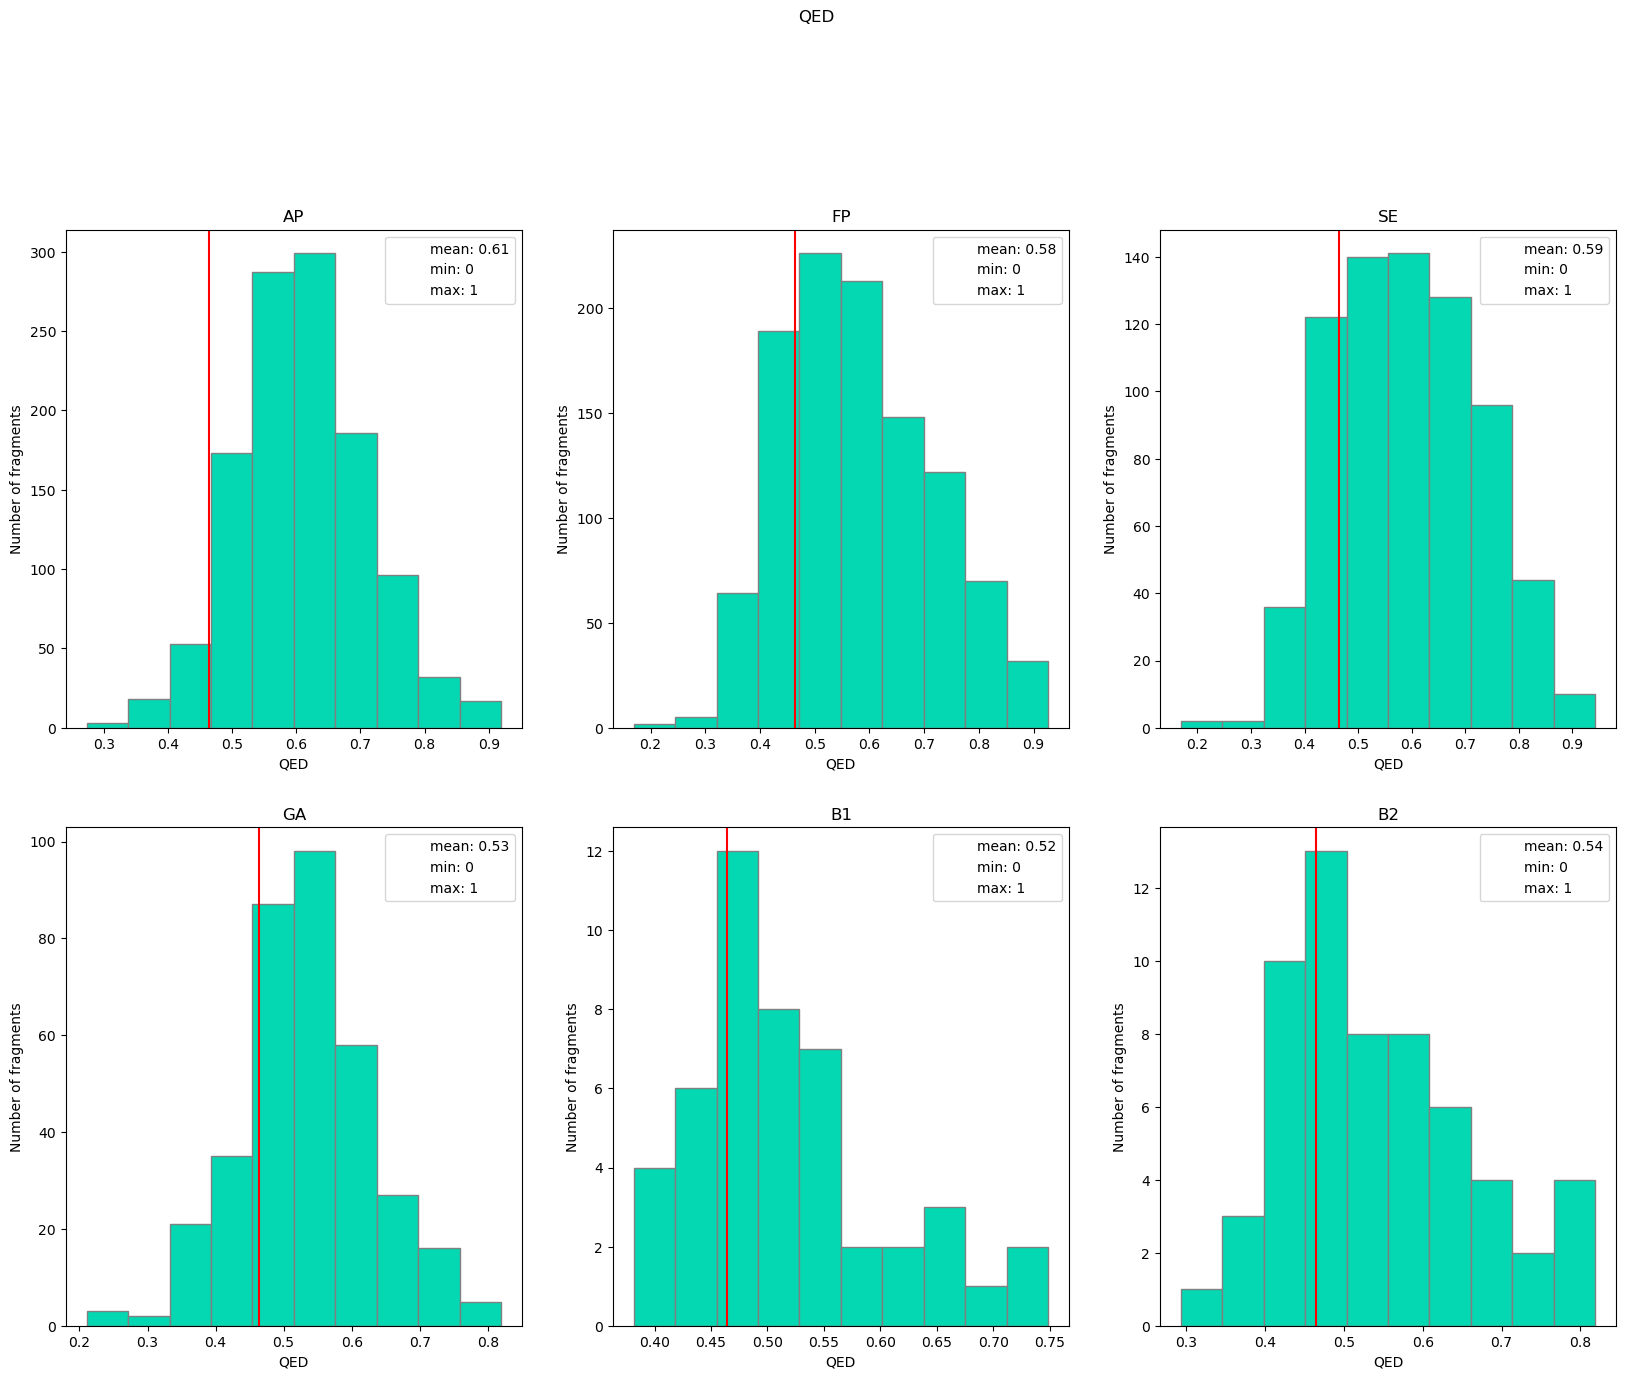

Apply BB filter..
Number of building blocks: 1803


,pre_filtered,accepted_enamine,rejected_enamine
AP,1164,540,624
FP,1071,555,516
SE,721,422,299
GA,352,300,52
B1,47,43,4
B2,59,51,8
Total,3414,1911,1503


Apply SYBA filter..


,pre_filtered,accepted_syba,rejected_syba
AP,1164,1033,131
FP,1071,843,228
SE,721,646,75
GA,352,325,27
B1,47,37,10
B2,59,53,6
Total,3414,2937,477


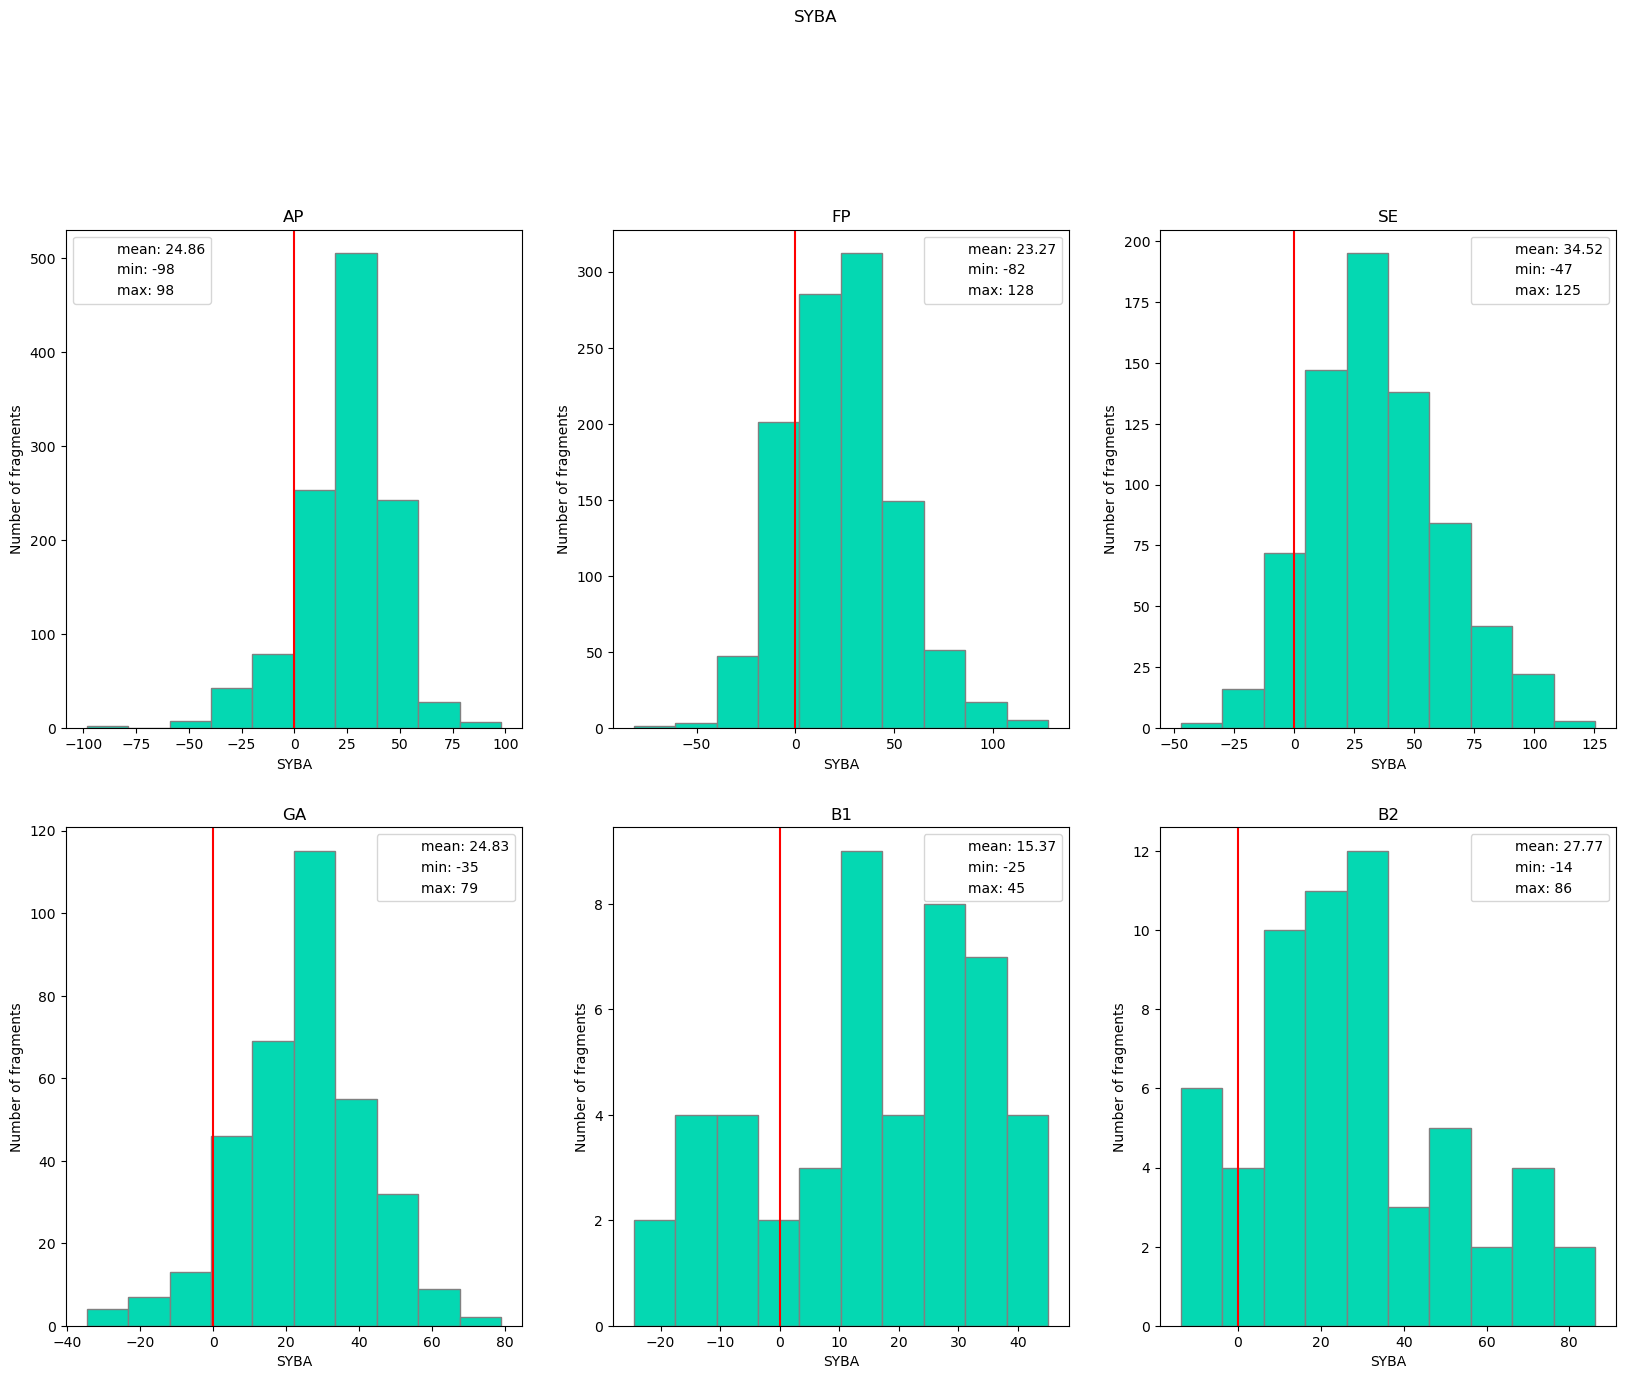

,pre_filtered,number of fragments used for pairwise retrosynthesizability
AP,1164,272
FP,1071,254
SE,721,229
GA,352,147
B1,47,19
B2,59,30
Total,3414,951


Apply pairwise retrosynthesizability filter..
Number of fragments:  951
Number of unique pairs: 63493
ASKCOS query started for 0 fragments.
ASKCOS query finished.
Comparing ASKCOS children with fragments..
Checking if all fragment pairs were requested..
All fragment pairs were requested.
Done.


,custom_filtered,accepted_pairwise_retosynthesizability,rejected_pairwise_retosynthesizability
subpocket,,,
AP,272,179,93
FP,254,244,10
SE,229,228,1
GA,147,142,5
B1,19,18,1
B2,30,26,4
Total,951,837,114


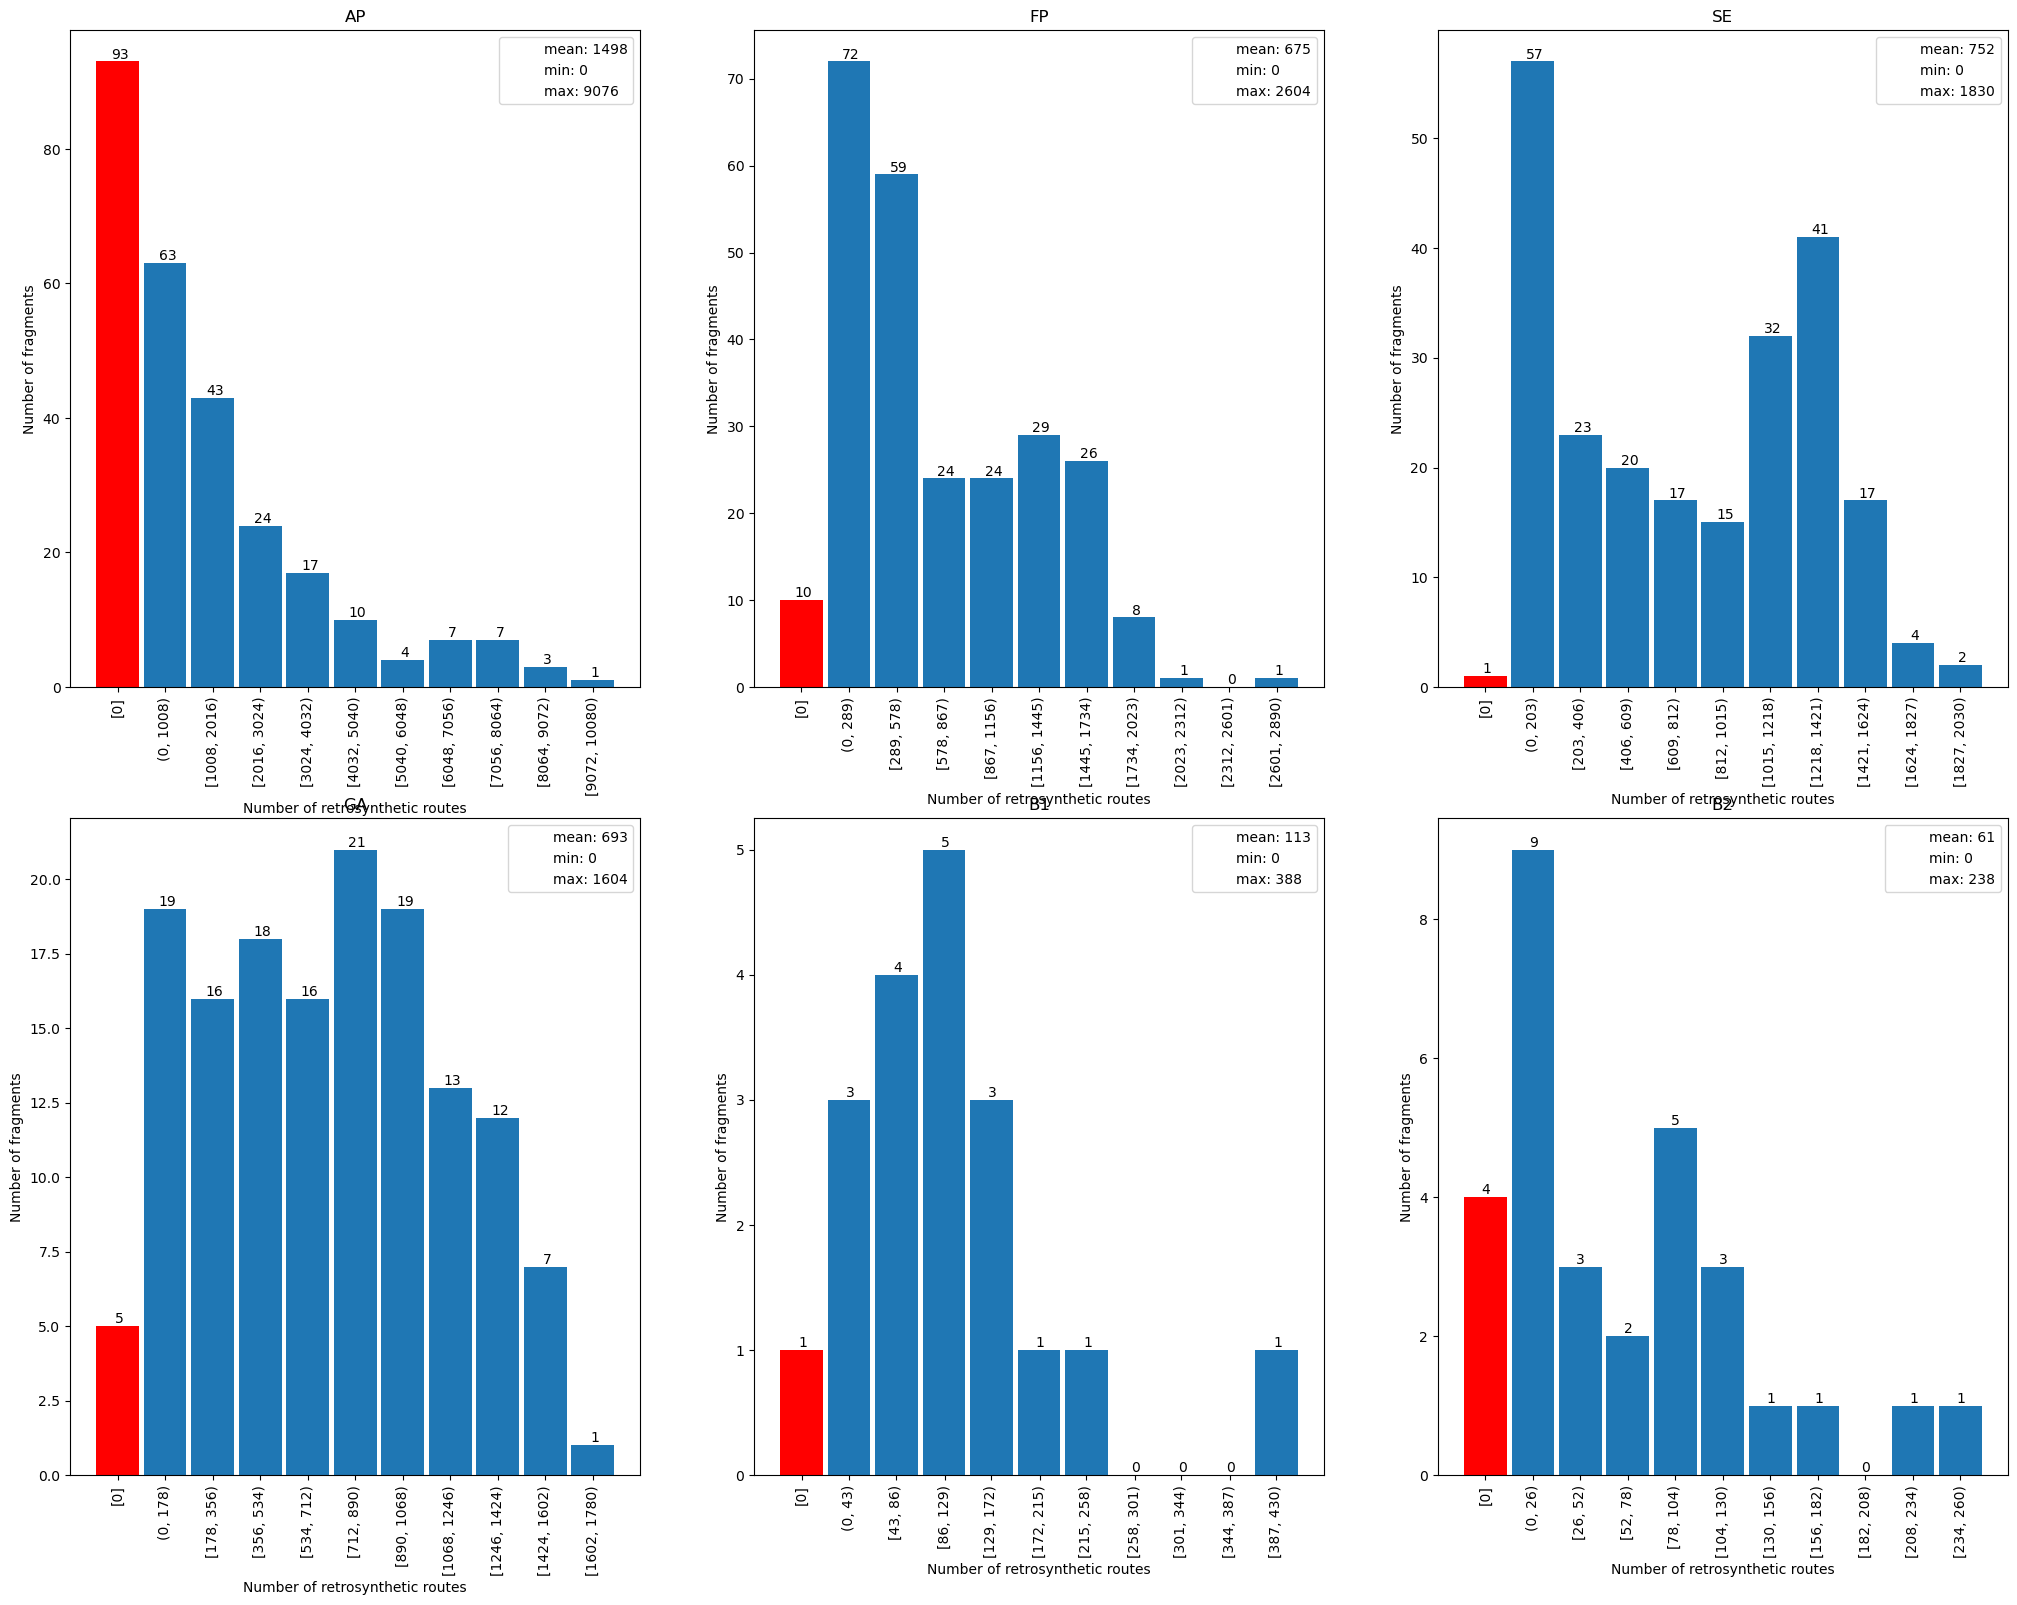

93 AP fragments with no retrosynthetic route found


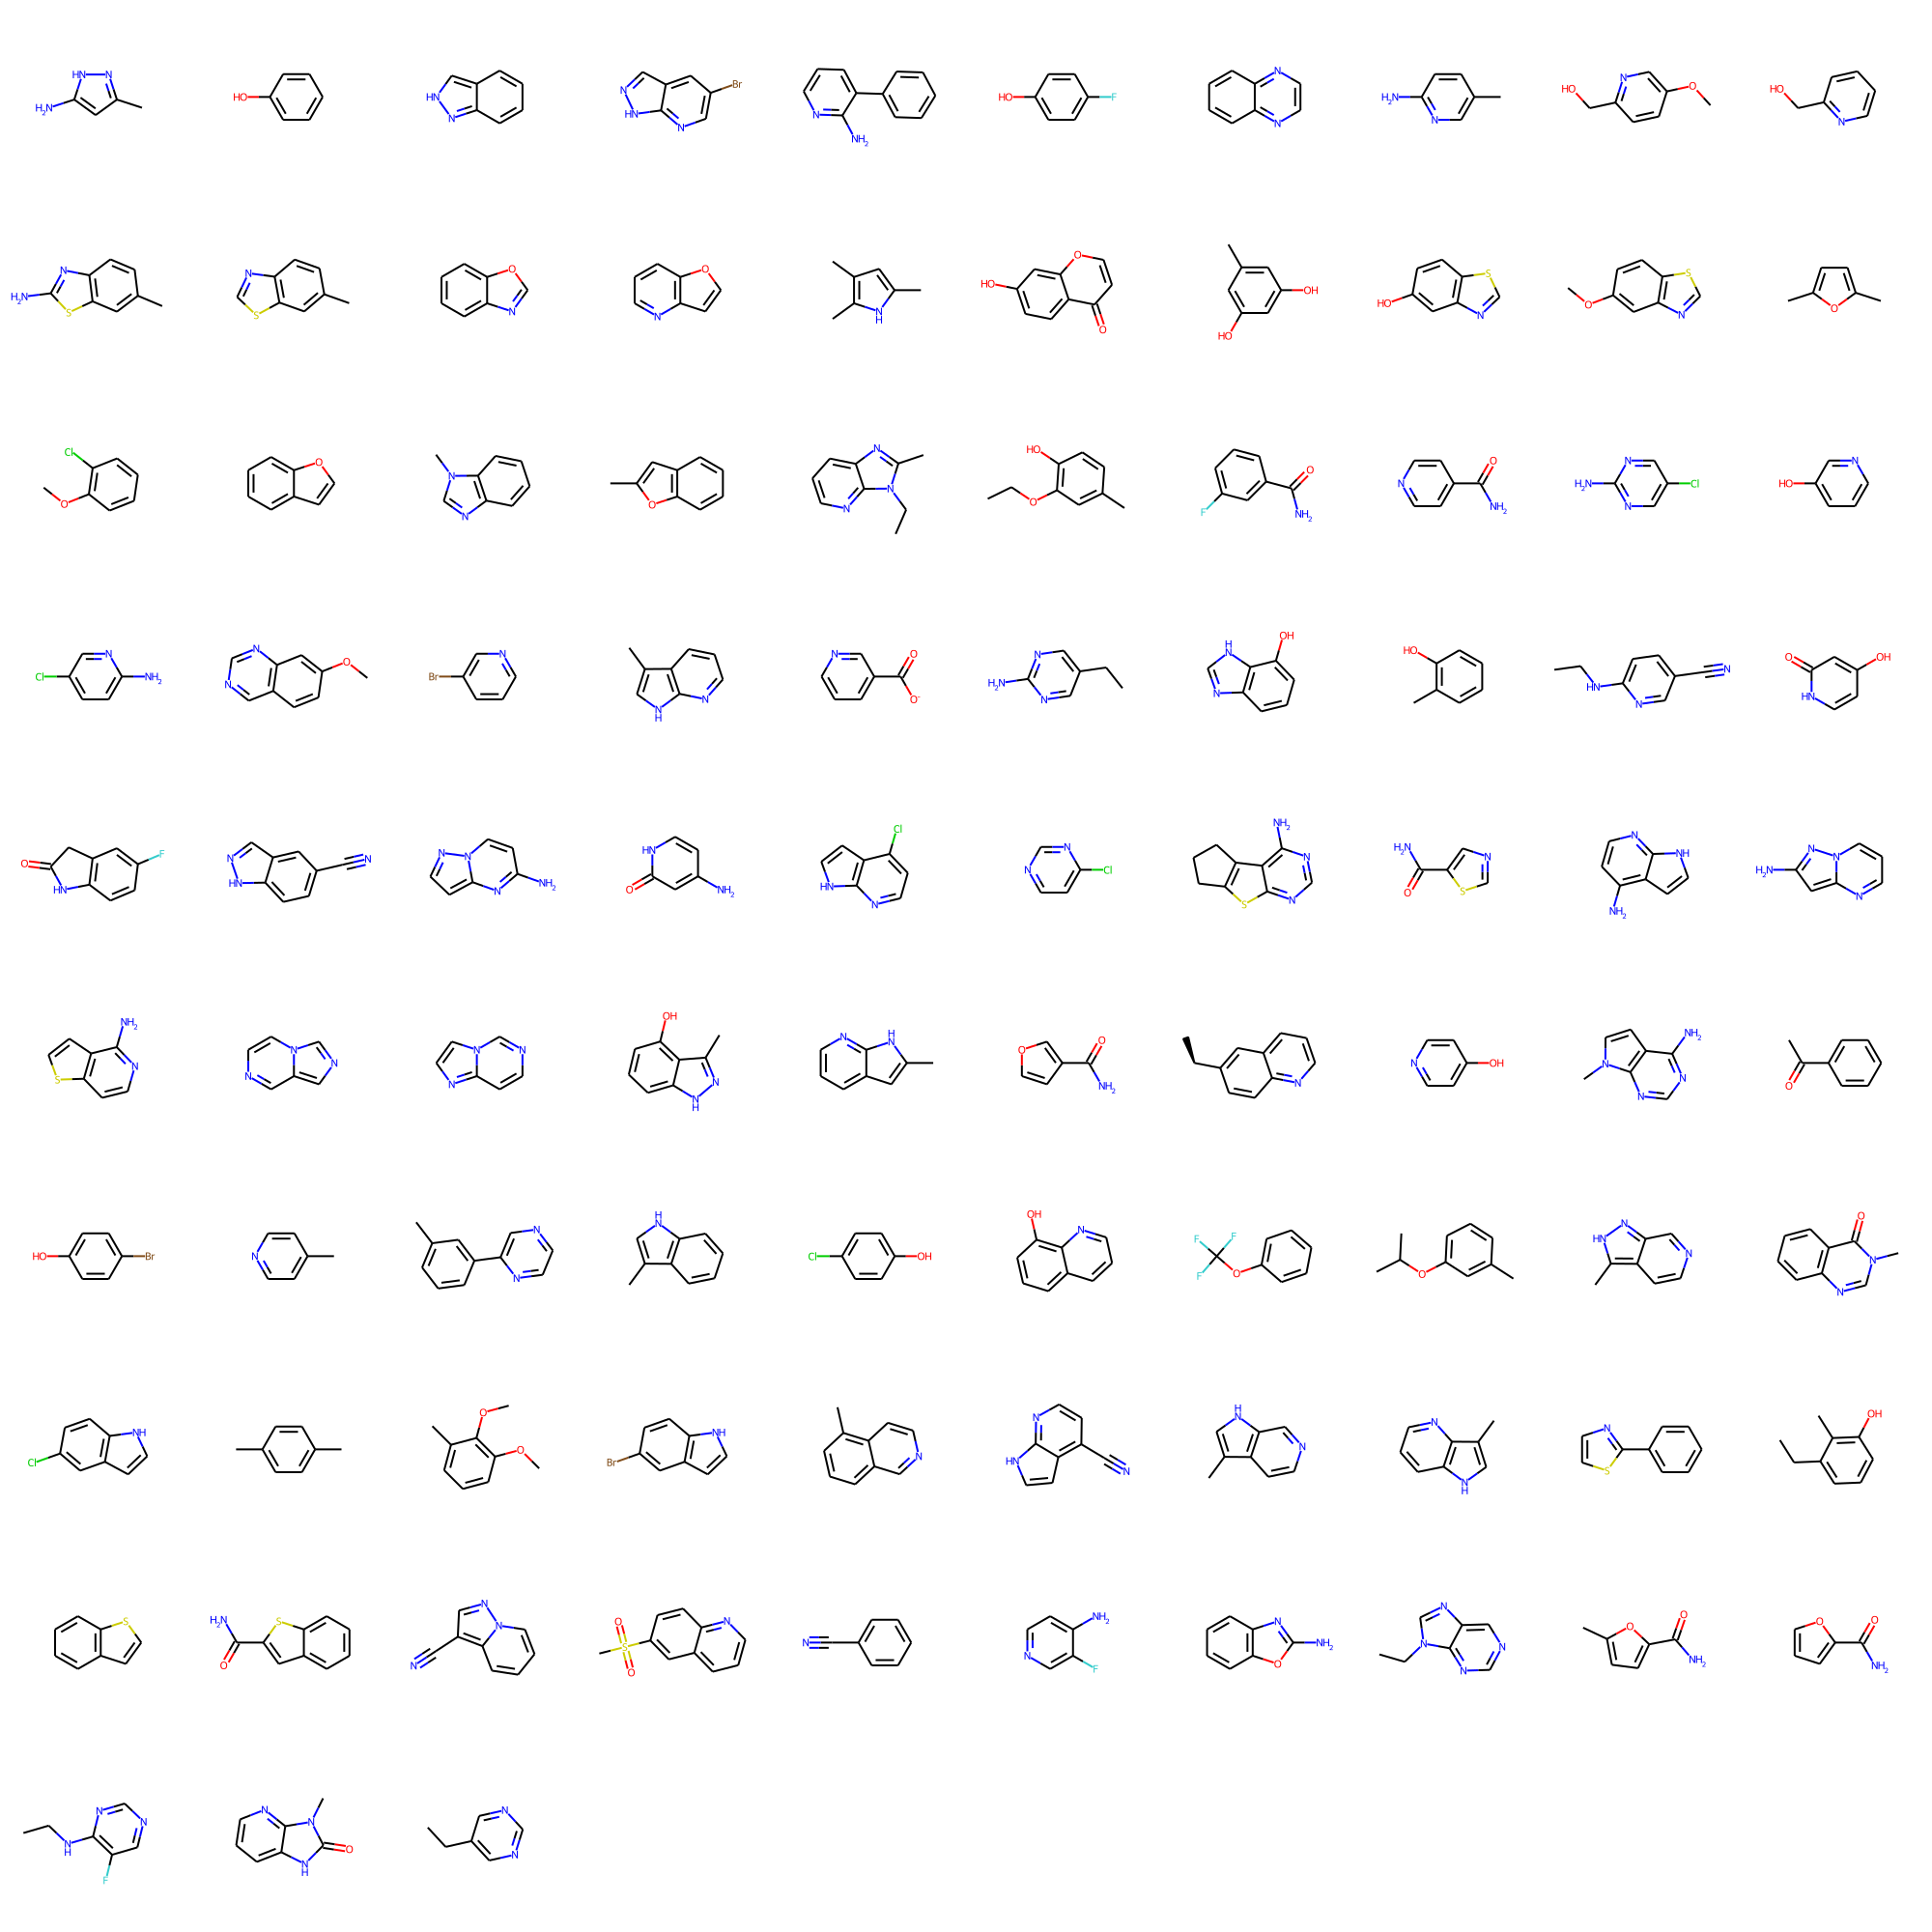

10 AP fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


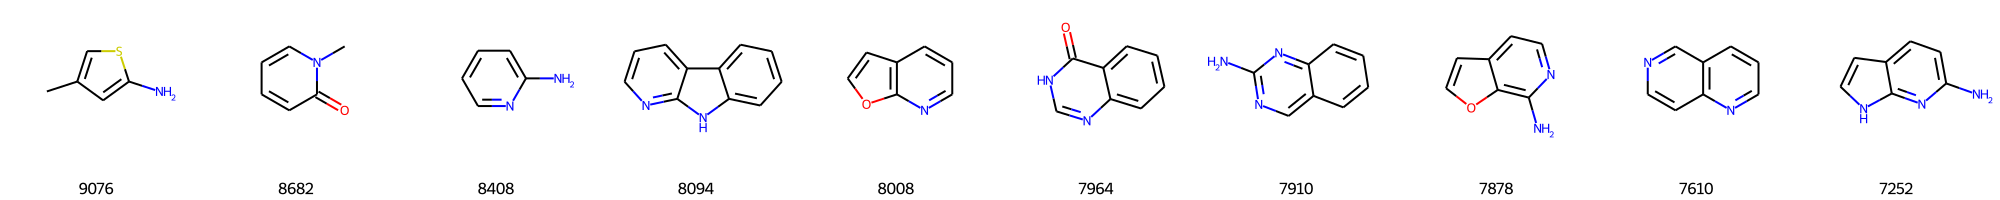

10 FP fragments with no retrosynthetic route found


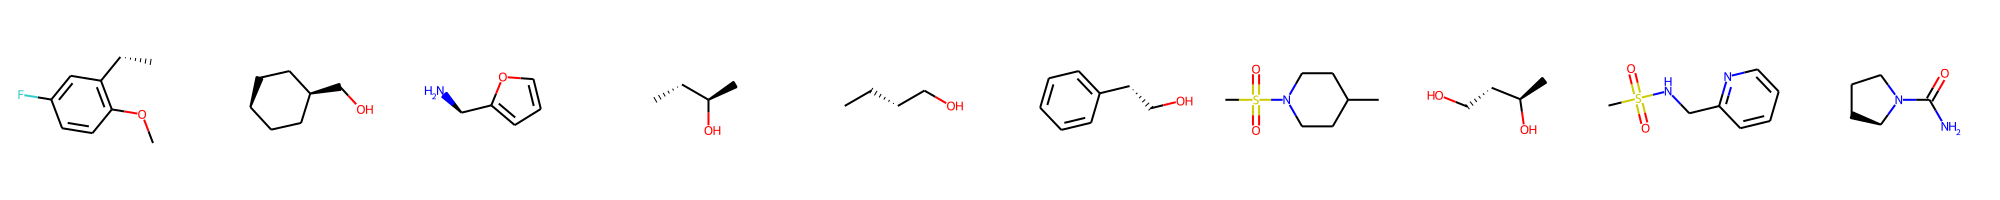

10 FP fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


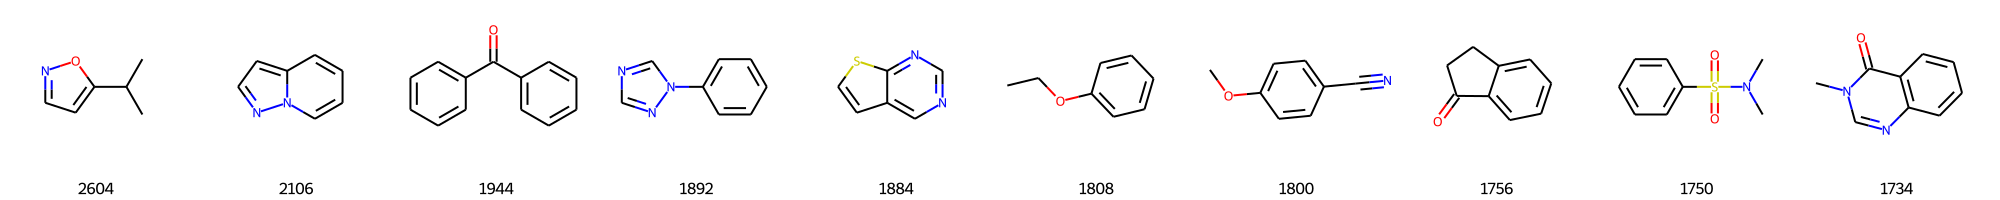

1 SE fragments with no retrosynthetic route found


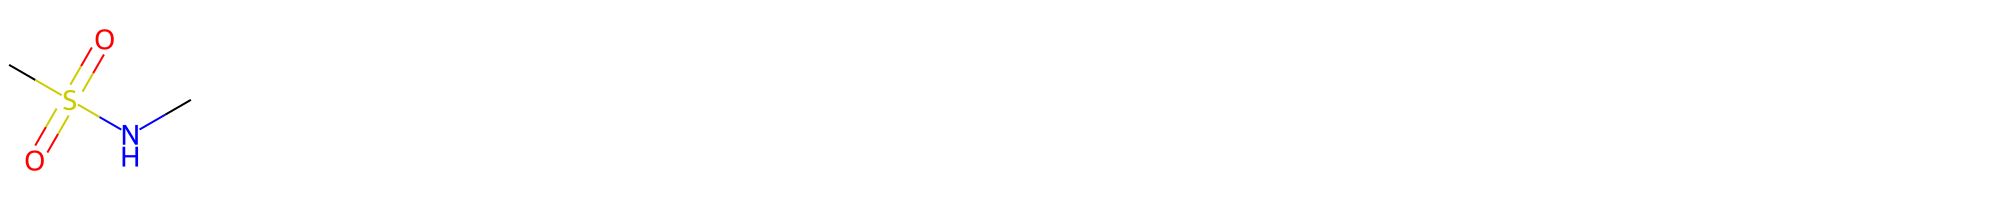

10 SE fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


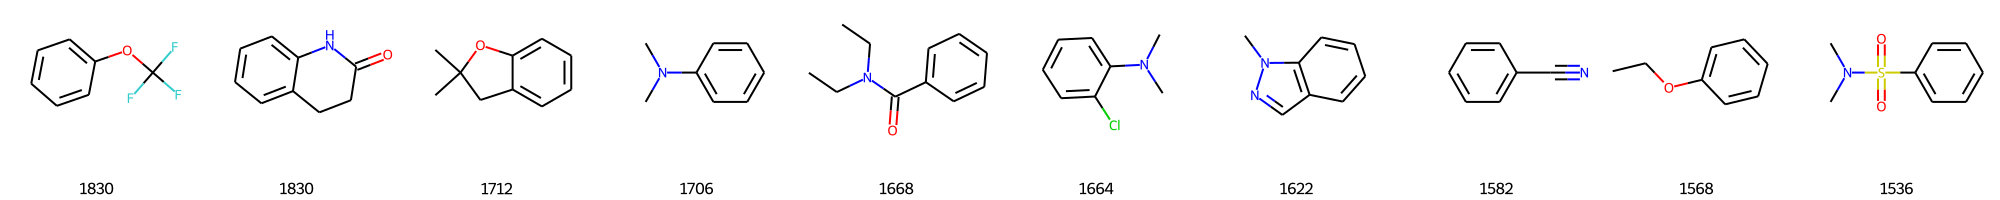

5 GA fragments with no retrosynthetic route found


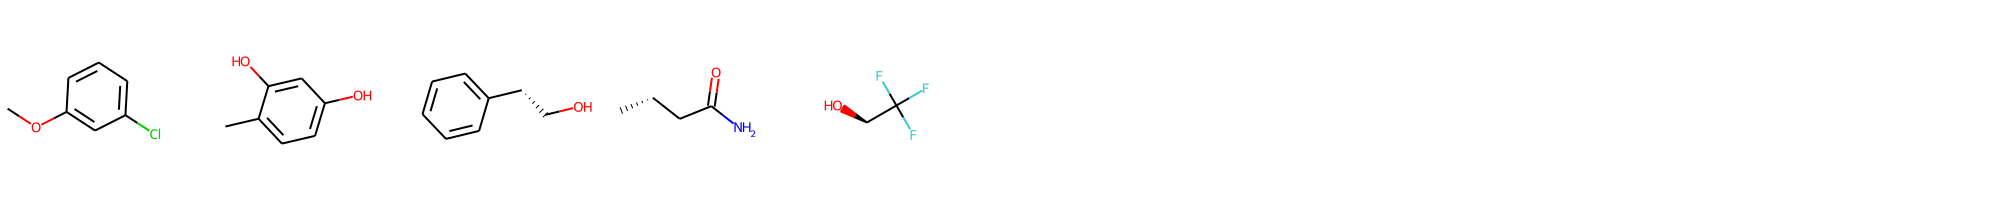

10 GA fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


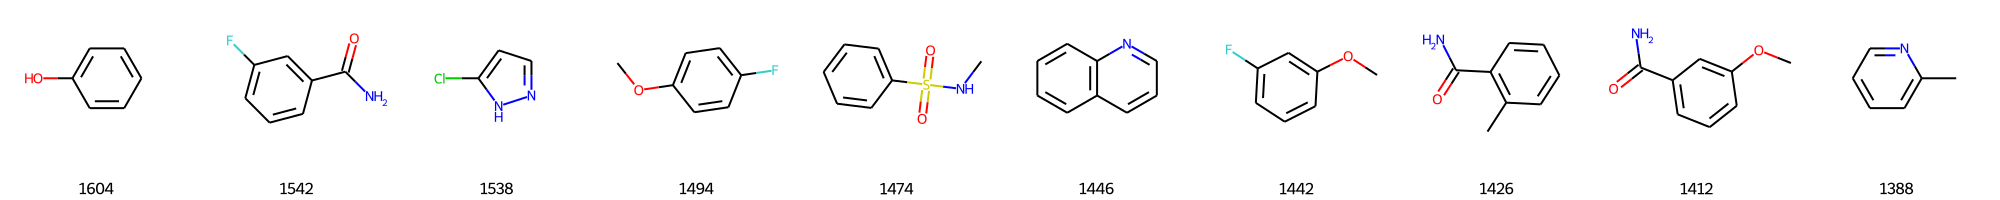

1 B1 fragments with no retrosynthetic route found


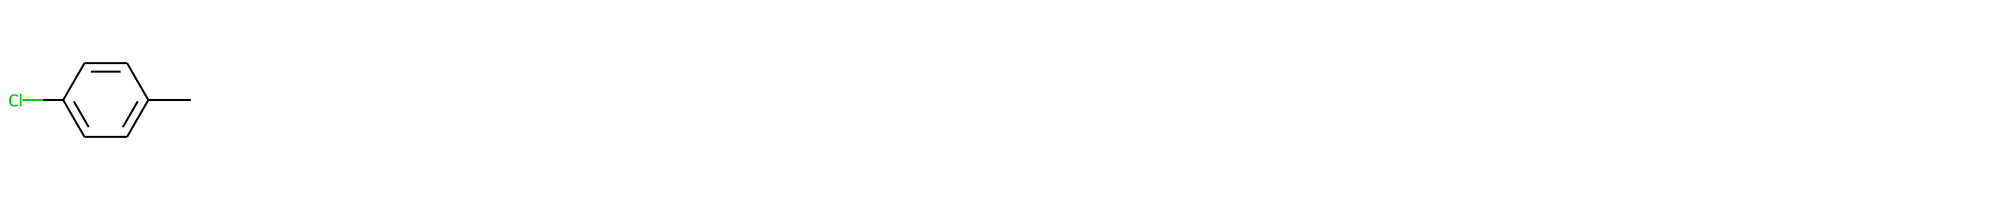

10 B1 fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


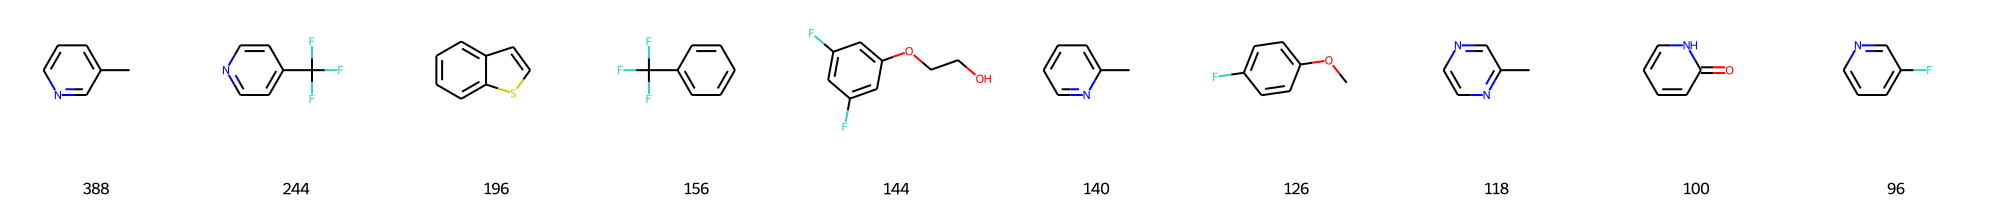

4 B2 fragments with no retrosynthetic route found


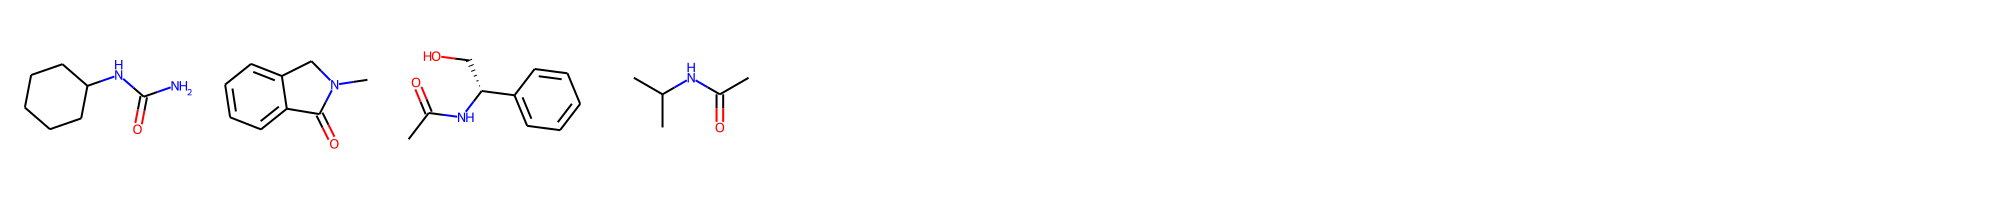

10 B2 fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


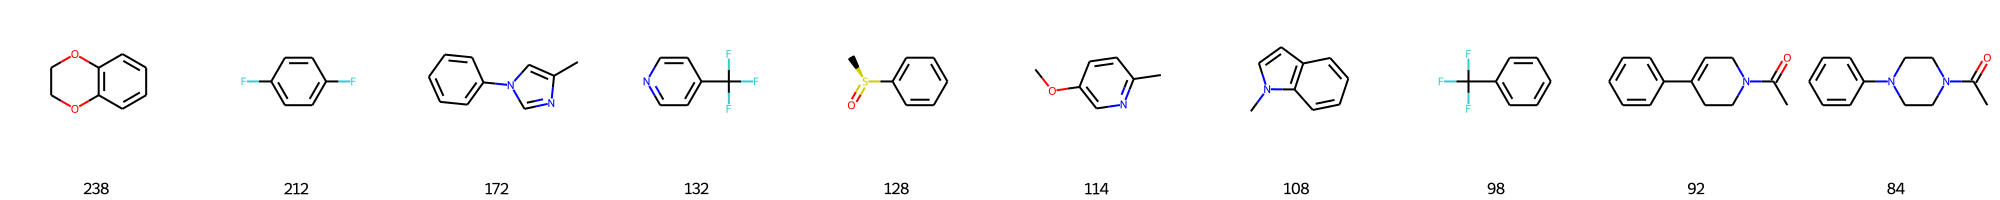

Save custom filtered fragment library to data/fragment_library_custom_filtered/2025-11-12_15-31-41


In [17]:
pipeline_dict = filters.pipeline.start_pipeline(
    fragment_library,
    pains_parameters,
    brenk_parameters,
    ro3_parameters,
    qed_parameters,
    bb_parameters,
    syba_parameters,
    retro_parameters,
    global_parameters,
)

## 5. Inspect results

Load and inspect the results from the single filters.
The `custom_filter_results.csv` file is stored in the `/data/fragment_library_custom_filtered` directory.

**Note:** If you want your filter results displayed please adapt the path to your created datetime folder in this directory by simply adding the folder name in front of the .csv file e.g. `saved_filter_results = pd.read_csv(PATH_DATA_CUSTOM / "YYYY-MM-DD_HH-MM-SS/custom_filter_results.csv")`

In [18]:
saved_filter_results = pd.read_csv(PATH_DATA_CUSTOM / "custom_filter_results.csv", na_values=[""])
saved_filter_results

,smiles,subpocket,bool_pains,bool_brenk,bool_ro3,bool_qed,qed,bool_bb,bool_syba,syba,retro_count,bool_retro
0,Nc1c[nH]c2ncccc12,AP,1,1,1,1,0.565900,1,1,30.950959,6520.0,1.0
1,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,AP,1,0,1,1,0.747185,0,1,17.682659,NaN,NaN
2,CC1=C2/C(=N/c3ccccc3)N=CN=[N+]2C=C1,AP,1,0,0,1,0.656515,0,1,0.611823,NaN,NaN
3,Nc1ncnn2cccc12,AP,1,1,1,1,0.563803,1,1,28.754427,484.0,1.0
4,Cc1cc(N)[nH]n1,AP,1,1,1,1,0.488854,1,1,15.727015,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3409,c1cnoc1,B2,1,1,1,0,0.447261,1,1,11.831072,NaN,NaN
3410,c1ccoc1,B2,1,1,1,0,0.446031,1,1,5.852398,NaN,NaN
3411,CNC,B2,1,1,1,0,0.398671,1,1,10.078885,NaN,NaN
3412,c1ccc(N2CCOCC2)nc1,B2,1,1,1,1,0.616781,0,1,48.630055,NaN,NaN


**Note:** NaN in the `retro_count` and `bool_retro` column indicated that this fragment was not included in the pairwise retrosynthesizability filter step.

The following data is generated when the according filters are activated:
- `pains_df`: PAINS structures found per fragment (first match only).
- `brenk_df`: Brenk structures and structure name found per fragment (first match only)
- `mol_df`: Contains fragment pairs, fragments building these pairs, ASKCOS children and plausibility for those pairs where the fragments are substructures of the children
- `diff_df`: Contains fragment pairs, fragments building these pairs, ASKCOS children and plausibility for those pairs where the fragments are NOT substructures of the children

In [19]:
pipeline_dict.keys()

dict_keys(['fragment_library', 'pains_df', 'brenk_df', 'mol_df', 'diff_df'])

In [20]:
fragment_library_custom = pipeline_dict["fragment_library"]
pains_df = pipeline_dict["pains_df"]
brenk_df = pipeline_dict["brenk_df"]
mol_df = pipeline_dict["mol_df"]
diff_df = pipeline_dict["diff_df"]

Inspect `fragment_library_custom` contains the fragments passing all filters applied.

,subpocket,standardized_inchi,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,fragment_count,connections,connections_name,bool_pains,bool_brenk,bool_ro3,bool_qed,qed,bool_bb,bool_syba,syba,bool,retro_count,bool_retro
0,AP,HCTKTFWOSSBSIL-UHFFFAOYSA-N,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1,1,1,1,0.565900,1,1,30.950959,1,6520,1
1,AP,VSPXQZSDPSOPRO-UHFFFAOYSA-N,,,,AAK1,NAK,Other,8gmd,ZRR,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP GA FP,14 14 14 14 14 14 14 16 14 14 14 14 5 5 na na,Nc1ncnn2cccc12,*Nc1ncnn2ccc([25*])c12,6,"[GA, FP]","[AP=GA, AP=FP]",1,1,1,1,0.563803,1,1,28.754427,1,484,1
3,AP,AXWBJJJQRJBTMI-UHFFFAOYSA-N,,,,ACK,Ack,TK,4ewh,T77,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 16 14 5 5 4 4 4 na ...,CNc1ncnc2[nH]ccc12,[26*]c1[nH]c2ncnc(NC[54*])c2c1[37*],11,"[FP, SE, FP]","[AP=FP, AP=SE, AP=FP]",1,1,1,1,0.633912,1,1,38.386371,1,1858,1
4,AP,LDIJKUBTLZTFRG-UHFFFAOYSA-N,,,,ACTR2,STKR,TKL,3q4t,TAK,A,B,AP AP AP AP AP AP AP AP AP AP AP AP SE GA,16 16 16 16 16 16 16 16 16 16 16 16 na na,c1cnc2ccnn2c1,[33*]c1cnc2c([46*])cnn2c1,11,"[SE, GA]","[AP=SE, AP=GA]",1,1,1,1,0.511376,1,1,39.622898,1,6668,1
5,AP,MXVAGCQKBDMKPG-UHFFFAOYSA-N,,,,ACTR2,STKR,TKL,3soc,GVD,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,15 15 15 15 15 15 15 15 14 14 14 14 14 14 14 5...,Nc1cc(C2CC2)[nH]n1,[17*]Nc1cc(C2CC2)[nH]n1,5,[SE],[AP=SE],1,1,1,1,0.581756,1,1,18.524861,1,1068,1

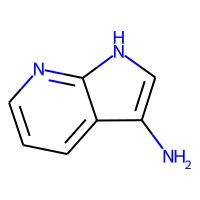
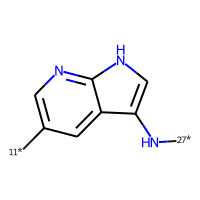
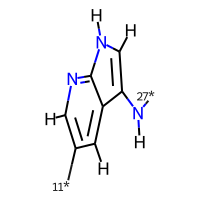
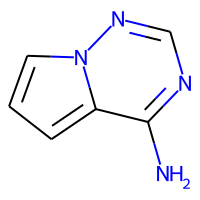
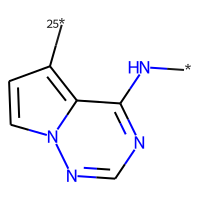
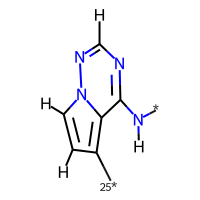
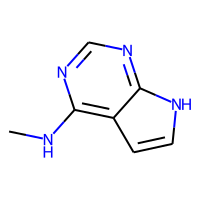
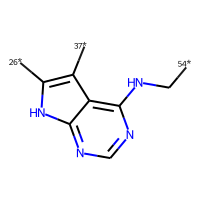
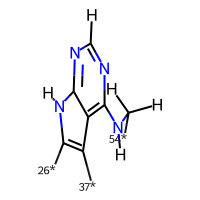
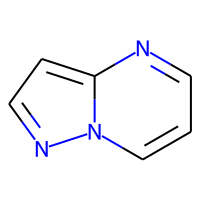
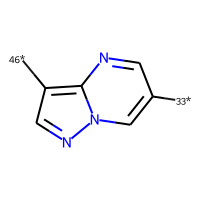
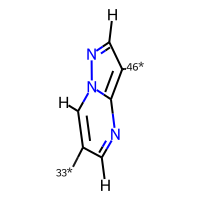
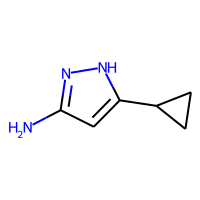
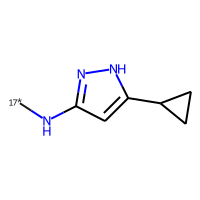
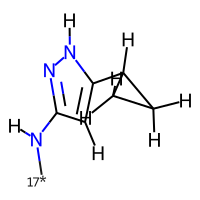

In [21]:
HTML(fragment_library_custom["AP"].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Inspect `pains_df` containing the fragments and the name of the first PAINS structure found in this fragment.

,0,1,2,3,4
fragment,,,,,
pains,Imine_one_isatin(189),Imine_one_isatin(189),Imine_one_isatin(189),Quinone_a(370),Thio_ketone(43)

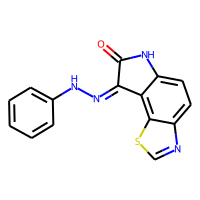
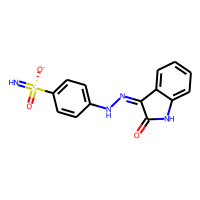
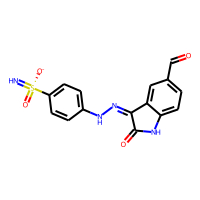
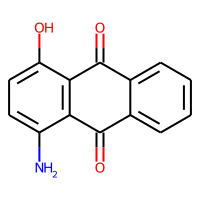
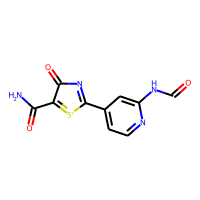

In [22]:
HTML(pains_df.head().T.to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Inspect `brenk_df` containing the fragment and the first substructure from the list from Brenk et al. and the name of the substructure found.

,0,1,2,3,4
fragment,,,,,
substructure,,,,,
substructure_name,Michael-acceptor,stilbene,imine,quaternary-nitrogen,aldehyde

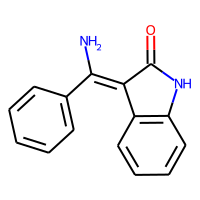
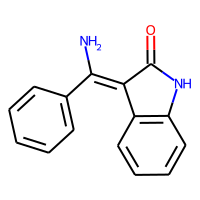
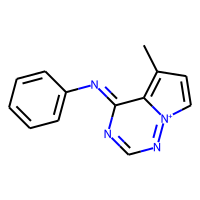
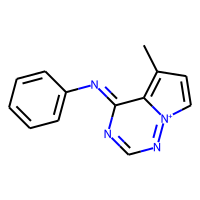
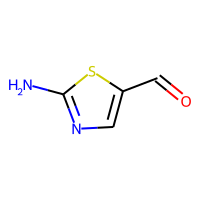
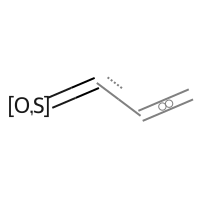
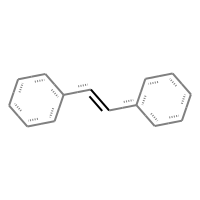
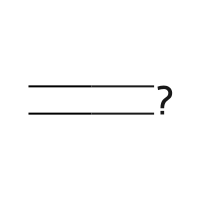
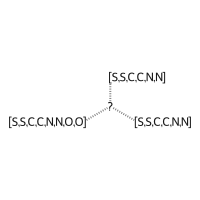
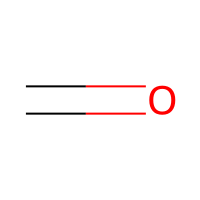

In [23]:
HTML(brenk_df.head().T.to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Inspect `mol_df` containing all fragments and pairs with a retrosynthetic route found, and the children building this fragment pair from ASKCOS.

,fragment ids,fragment 1,fragment 2,pair,child 1,child 2,plausibility
0,"[AP_0, FP_0]",,,,,,0.999993
1,"[AP_0, FP_0]",,,,,,0.999999
2,"[AP_0, FP_0]",,,,,,0.998543
3,"[AP_0, FP_0]",,,,,,0.999301
4,"[AP_0, FP_1]",,,,,,0.999674

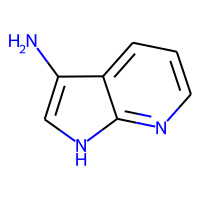
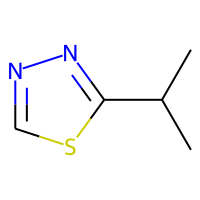
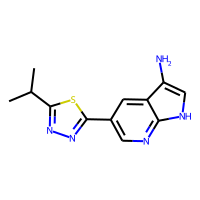
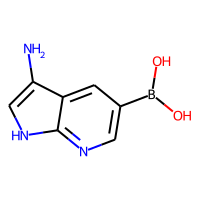
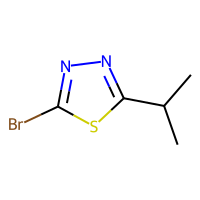
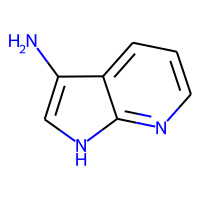
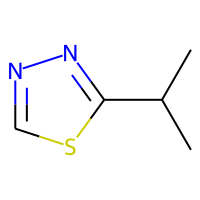
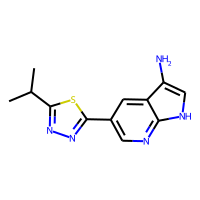
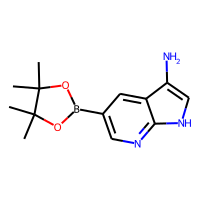
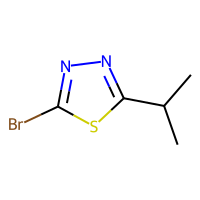
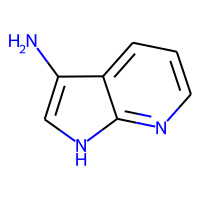
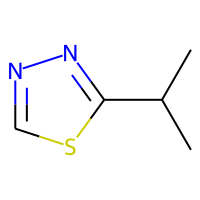
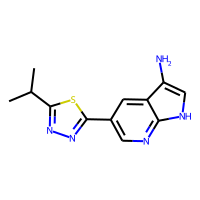
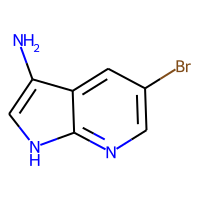
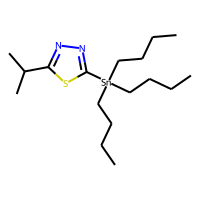
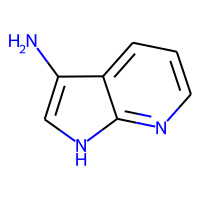
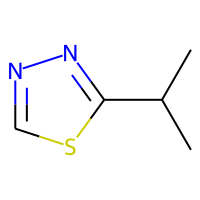
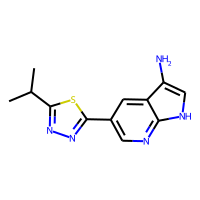
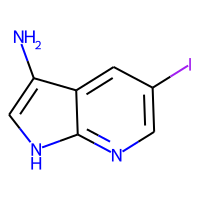
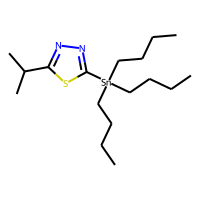
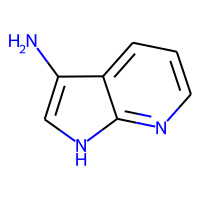
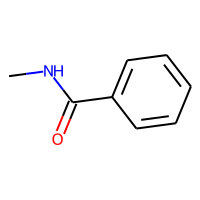
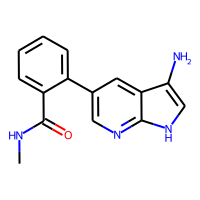
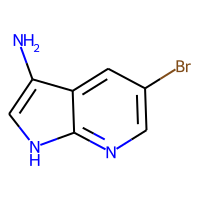
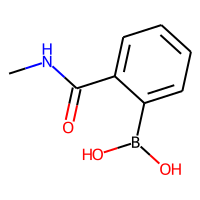

In [24]:
HTML(mol_df.head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Inspect `diff_df` containing all fragments and pairs where a retrosynthetic route was found, but the fragments and children structures are not matching.

,fragment ids,fragment 1,fragment 2,pair,child 1,child 2,plausibility
0,"[AP_0, FP_4]",,,,,,0.973950
1,"[AP_0, FP_4]",,,,,,0.999941
2,"[AP_0, FP_13]",,,,,,0.847939
3,"[AP_0, FP_13]",,,,,,0.812678
4,"[AP_0, FP_22]",,,,,,0.991071

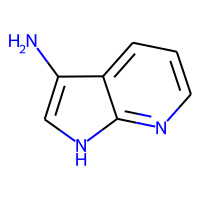
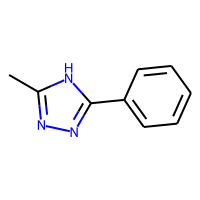
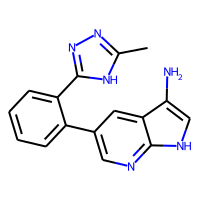
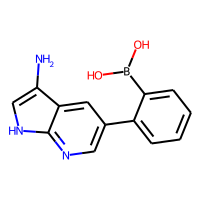
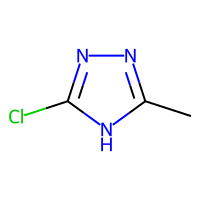
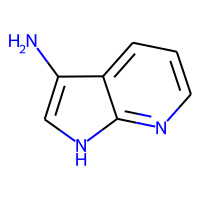
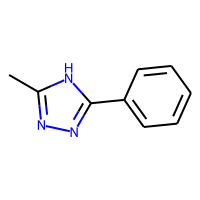
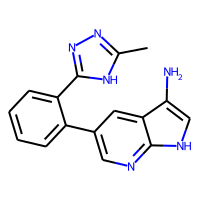
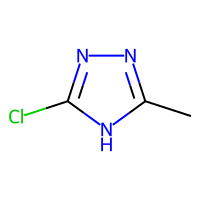
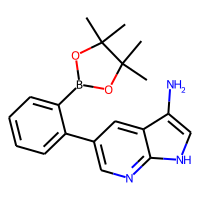
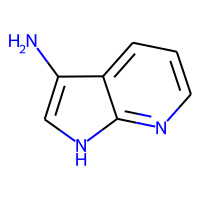
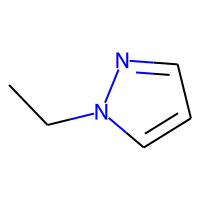
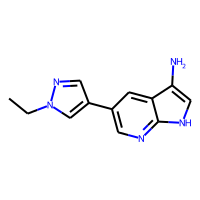
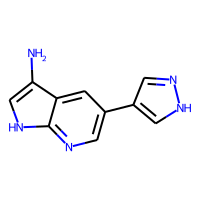
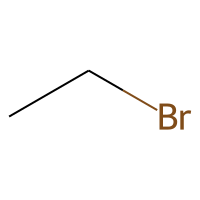
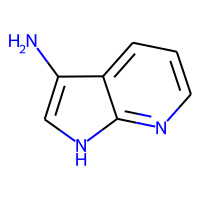
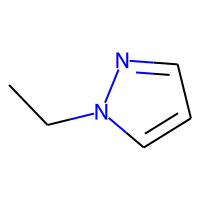
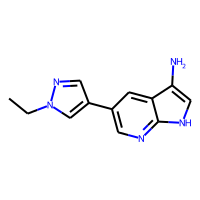
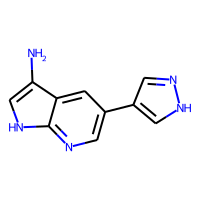
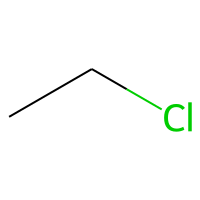
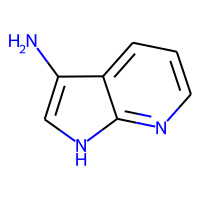
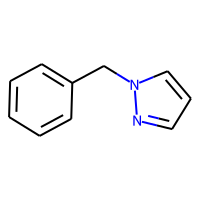
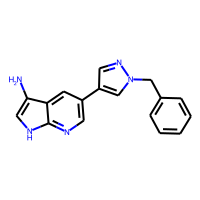
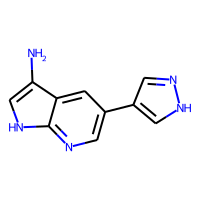
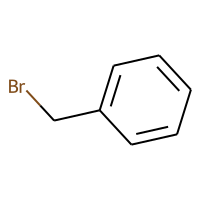

In [25]:
HTML(diff_df.head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT